<a href="https://colab.research.google.com/github/abhitall/Sketch2Code/blob/main/Sketch2Code_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries

from __future__ import division, print_function, absolute_import
import time, sys, os, random, cv2, pprint, math, pickle
from copy import deepcopy
from shutil import copy, move
from optparse import OptionParser

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import PIL as pil
from skimage import io
from sklearn.metrics import average_precision_score

import tensorflow as tf

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy
from keras.models import Model
from keras.utils import generic_utils
from keras.utils import plot_model
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


In [ ]:
# grabing dataset from Google Drive
# This only needs to be done once per notebook.

# Installing PyDrive wrapper & importing related libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentication and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Downloading dataset archive based on its file ID.
download = drive.CreateFile({'id': '1Rz5iWmdZOLjWsGuQJ9CPGe_3rJNMXtqj'})
download.GetContentFile('sketchs.zip')


    100% |████████████████████████████████| 993kB 21.9MB/s 


In [ ]:
# extracting and cleaning up archive
# This only needs to be done once per notebook.

# extracting archive
!unzip sketchs.zip
# cleaning up archive file
!rm sketchs.zip

Archive:  sketchs.zip
  inflating: sketchs/class_descriptions.csv  
  inflating: sketchs/dataset.csv     
  inflating: sketchs/dataset.json    
   creating: sketchs/web/
  inflating: sketchs/web/05495118-dcee-4e4e-bee1-b6823096e2b7.html  
  inflating: sketchs/web/05495118-dcee-4e4e-bee1-b6823096e2b7.png  
  inflating: sketchs/web/094573f5-917f-4350-b8b5-3c828c834b57.html  
  inflating: sketchs/web/094573f5-917f-4350-b8b5-3c828c834b57.png  
  inflating: sketchs/web/0bb2725b-88b4-4734-98f1-3d7d860434e9.html  
  inflating: sketchs/web/0bb2725b-88b4-4734-98f1-3d7d860434e9.png  
  inflating: sketchs/web/0e883baf-e153-4a42-8e0c-f8cde7c179c3.png  
  inflating: sketchs/web/0f5761f9-a85c-4b7f-949a-189ab7cf853e.html  
  inflating: sketchs/web/0f5761f9-a85c-4b7f-949a-189ab7cf853e.png  
  inflating: sketchs/web/125ccd38-5f68-48c0-b060-8fb08dca2eca.html  
  inflating: sketchs/web/125ccd38-5f68-48c0-b060-8fb08dca2eca.png  
  inflating: sketchs/web/12ca11b1-9d0b-475b-96c4-ce30aeb496ec.html  
  inflat

In [ ]:
# annotation_bbox dataframe
annotations_bbox = pd.read_csv('sketchs/dataset.csv')

# printing a random sample of entries
annotations_bbox.sample(10)

,id,width,height,tagId,left,top,region_width,region_height
1821,96b1c403-5923-47cb-8bd8-99b20e12620a,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.515000,0.696435,0.145833,0.068889
1407,26246a48-79ca-41d2-b578-5bd82ed14d05,1200,900,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.257360,0.497627,0.346629,0.139240
1146,bc18ff8e-a345-40ed-9f3e-ccaf0ca2141f,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.801519,0.226741,0.122507,0.074684
165,722b8c8f-7975-4fc7-abde-b27b3bd37883,1600,725,530d20f2-7260-42f1-bd42-bddca465c9e9,0.673275,0.587952,0.215859,0.099515
1183,b04dc998-9b68-4d01-9670-0727d0d43617,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.766382,0.674842,0.138651,0.087342
363,3892666c-c7c7-4b69-9000-9f050d2ca7fb,1200,900,a04aa534-942d-4640-af99-39851705e59b,0.354575,0.297794,0.169118,0.065359
89,64090cc3-7882-419b-b22b-3b6f51fd5115,1600,621,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,0.264684,0.461481,0.150881,0.084986
1967,782ebd0a-b6bd-4607-a109-4beca493c694,1200,900,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.288333,0.173102,0.536667,0.127778
777,c0822cd3-0bcb-458b-8dba-eef63fe4e3a3,900,1200,b9944914-2e80-4b6a-8874-0fe55d073c45,0.128378,0.700158,0.456081,0.074684
1155,bc18ff8e-a345-40ed-9f3e-ccaf0ca2141f,1200,900,69576625-a3c1-40bb-8947-936491484048,0.625831,0.221677,0.048433,0.067089


In [ ]:
# renaming columns for convinience
annotations_bbox.rename(columns={'id': 'ImageID', 'tagId': 'LabelName', 'left': 'XMin', 'top': 'YMin'}, inplace=True)

# printing a random sample of entries
annotations_bbox.sample(10)

,ImageID,width,height,LabelName,XMin,YMin,region_width,region_height
129,236b436f-ce60-4a25-8e81-3603552536e3,1600,662,530d20f2-7260-42f1-bd42-bddca465c9e9,0.676579,0.515699,0.205947,0.101064
1681,feef1db7-6cbe-4d0d-9929-18e42ba09407,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.588333,0.254213,0.121667,0.077778
629,e61e2973-7712-4b2c-91e9-b3221756a220,1129,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.016207,0.541160,0.178282,0.083164
1104,8fd6acaf-cace-47c5-84bc-937773d65a55,1200,900,c266ec15-593b-425f-a6e1-384c4df0a781,0.501424,0.403956,0.470085,0.097468
433,d20b2bf2-ee77-404f-8de3-9238284d1957,1111,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.222039,0.739943,0.162829,0.075051
1435,3e6baa71-dc1e-4ec8-8a3f-a4349e6cbf1a,1200,900,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.265907,0.500158,0.331434,0.140506
1328,9f638ca2-de14-47dd-9f81-c697e849c3c5,1200,900,69576625-a3c1-40bb-8947-936491484048,0.600190,0.876108,0.250712,0.117722
945,48002818-9e4b-486c-96cf-db1052cda8b7,1200,900,530d20f2-7260-42f1-bd42-bddca465c9e9,0.566002,0.410285,0.144349,0.062025
1029,80ce0ae6-9f89-429b-b2da-ae1b25e45acb,1200,900,69576625-a3c1-40bb-8947-936491484048,0.464387,0.626740,0.201330,0.086076
604,770c6fbf-1046-4de3-a892-c1d53a9209ae,936,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.146484,0.204446,0.273438,0.050710


In [ ]:
# adding other required columns based on the information in annotations_bbox dataframe
annotations_bbox['XMax'] = annotations_bbox['XMin'] + annotations_bbox['region_width']
annotations_bbox['YMax'] = annotations_bbox['YMin'] + annotations_bbox['region_height']

#printing a random sample of entries
annotations_bbox.sample(10)

,ImageID,width,height,LabelName,XMin,YMin,region_width,region_height,XMax,YMax
799,fa3aae44-9496-4557-a085-d1407b5b3e8e,900,1200,c266ec15-593b-425f-a6e1-384c4df0a781,0.743243,0.771044,0.165541,0.083544,0.908784,0.854589
445,e4da414a-0ad2-4580-ab2e-039a06532ea9,900,1091,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,0.071429,0.460024,0.130542,0.162272,0.201970,0.622295
1293,12ca11b1-9d0b-475b-96c4-ce30aeb496ec,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.784425,0.411551,0.143400,0.073418,0.927825,0.484968
1206,2451e8de-9c13-40ab-ba9d-3141d9d2fdec,1200,900,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,0.092118,0.000158,0.770180,0.084810,0.862298,0.084968
1387,76f51eb5-afd2-4e83-82c0-a105b10dc6f1,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.048433,0.597627,0.178538,0.089873,0.226971,0.687500
700,85c935d2-a69a-4d58-907b-22cf24a53fd5,900,1259,c266ec15-593b-425f-a6e1-384c4df0a781,0.437168,0.201424,0.272566,0.062025,0.709735,0.263449
988,603eb545-1b3c-4e44-8d46-80c452d4fe3d,1200,900,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,0.290598,0.411551,0.117759,0.065823,0.408357,0.477373
691,85c935d2-a69a-4d58-907b-22cf24a53fd5,900,1259,b9944914-2e80-4b6a-8874-0fe55d073c45,0.226549,0.940665,0.509734,0.055696,0.736283,0.996361
418,d20b2bf2-ee77-404f-8de3-9238284d1957,1111,900,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,0.052632,0.009719,0.402961,0.091278,0.455592,0.100997
771,c0822cd3-0bcb-458b-8dba-eef63fe4e3a3,900,1200,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,0.084459,0.446994,0.586149,0.100000,0.670608,0.546994


In [ ]:
# creating a dataframe for class descriptions
class_descriptions = pd.read_csv('sketchs/class_descriptions.csv')

#printing all entries
class_descriptions.head(10)

,name,class
0,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,CheckBox
1,69576625-a3c1-40bb-8947-936491484048,Button
2,b9944914-2e80-4b6a-8874-0fe55d073c45,Label
3,530d20f2-7260-42f1-bd42-bddca465c9e9,RadioButton
4,c266ec15-593b-425f-a6e1-384c4df0a781,TextBox
5,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,Heading
6,a04aa534-942d-4640-af99-39851705e59b,ComboBox
7,66565887-d482-4579-ae34-d0ca1869f3d7,Link
8,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,Image
9,43525578-a7e1-4f18-9c3b-2c60952c1bb5,Paragraph


In [ ]:
# dataframe for storing image and its uri
images_boxable = pd.DataFrame({'image_name':annotations_bbox['ImageID'].unique() + '.png'})
images_boxable['image_uri'] = images_boxable.apply(lambda x: 'sketchs/web/' + x['image_name'], axis='columns')

# saving images_boxable as csv file
images_boxable.to_csv('sketchs/images_boxable_name.csv', index = False)

# printing a sample of images_boxable dataframe
images_boxable.sample(10)

,image_name,image_uri
48,504bd55e-069d-4a18-b535-da3ca2d45f56.png,sketchs/web/504bd55e-069d-4a18-b535-da3ca2d45f...
13,9e4b1496-e1cf-4bcc-9171-34e1fbbef25f.png,sketchs/web/9e4b1496-e1cf-4bcc-9171-34e1fbbef2...
79,1b1f4c8c-92a7-4000-8f07-471d6f8016b1.png,sketchs/web/1b1f4c8c-92a7-4000-8f07-471d6f8016...
140,094573f5-917f-4350-b8b5-3c828c834b57.png,sketchs/web/094573f5-917f-4350-b8b5-3c828c834b...
22,995d99ba-02a3-42ed-9841-fa7b7a6e967c.png,sketchs/web/995d99ba-02a3-42ed-9841-fa7b7a6e96...
130,b5e97de6-94ce-49e9-8553-ca8a8653f35d.png,sketchs/web/b5e97de6-94ce-49e9-8553-ca8a8653f3...
4,f1f0f46b-4430-4227-ab3a-24ad1192728e.png,sketchs/web/f1f0f46b-4430-4227-ab3a-24ad119272...
80,41bd3b56-732a-4a13-a23a-1619dd33f216.png,sketchs/web/41bd3b56-732a-4a13-a23a-1619dd33f2...
111,54f95c56-6e1e-42b9-b0ee-2f9de7134c6e.png,sketchs/web/54f95c56-6e1e-42b9-b0ee-2f9de7134c...
65,6e9ac9b9-b034-49e5-8aac-911b7a482dfd.png,sketchs/web/6e9ac9b9-b034-49e5-8aac-911b7a482d...


In [ ]:
# total number of images 
print('length of the images_boxable: %d' %(len(images_boxable)))

#printing a sample
img_name = images_boxable['image_name'][random.randint(1,len(images_boxable))]
img_uri = images_boxable['image_uri'][random.randint(1,len(images_boxable))]
print('\t image_name: %s' % (img_name))
print('\t img_uri: %s' % (img_uri))
print('')

# total number of bounding boxes
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')

# total number of classes
print('length of the class_descriptions: %d' % (len(class_descriptions)))

length of the images_boxable: 149
	 image_name: b61a2a6c-c46d-4575-a091-3508bf0b2b88.png
	 img_uri: sketchs/web/6450fc7c-cd20-4f5d-a41d-c23bba871984.png

length of the annotations_bbox: 2001
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 10


(1600, 810, 3)


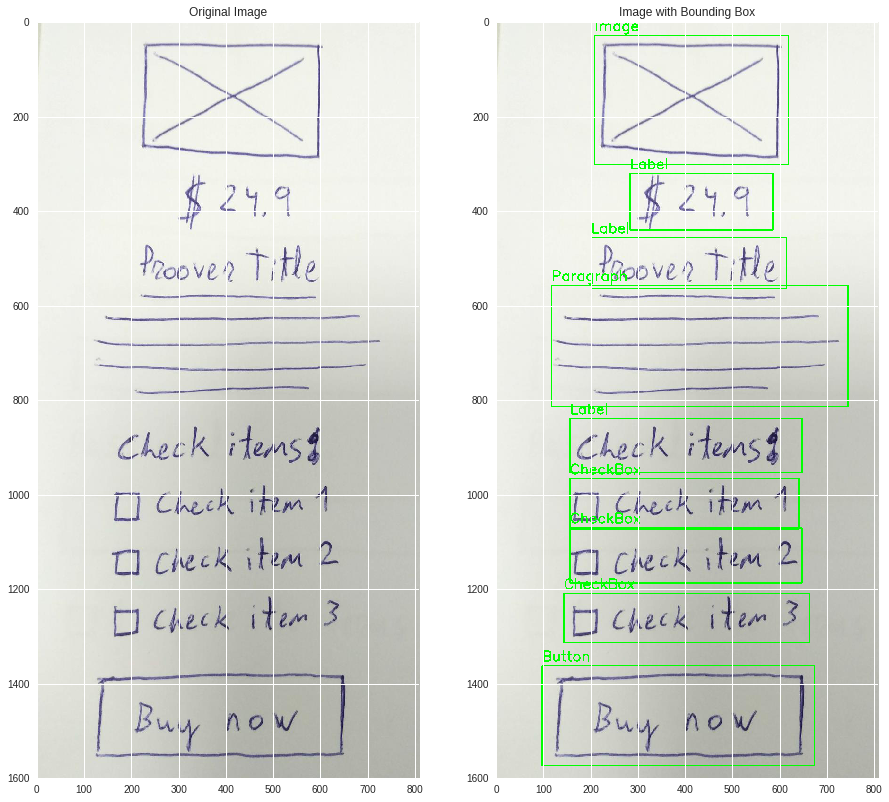

(900, 1148, 3)


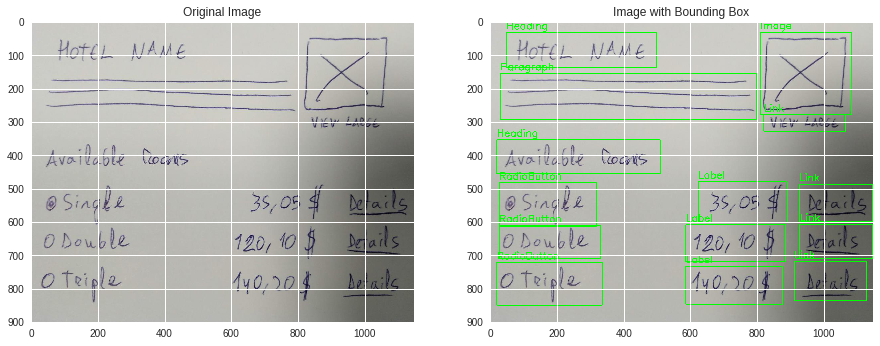

(277, 1600, 3)


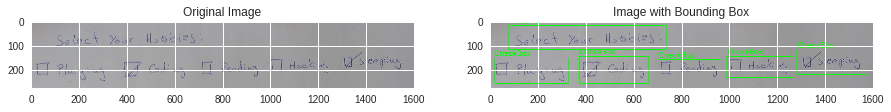

(1600, 783, 3)


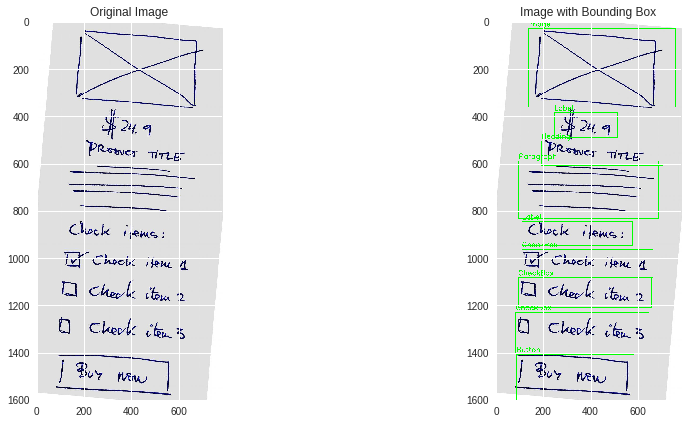

(838, 1600, 3)


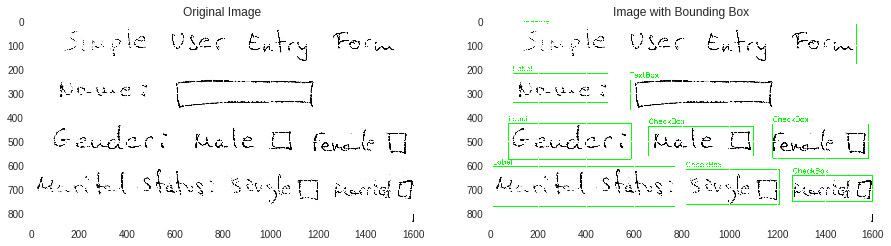

(900, 1200, 3)


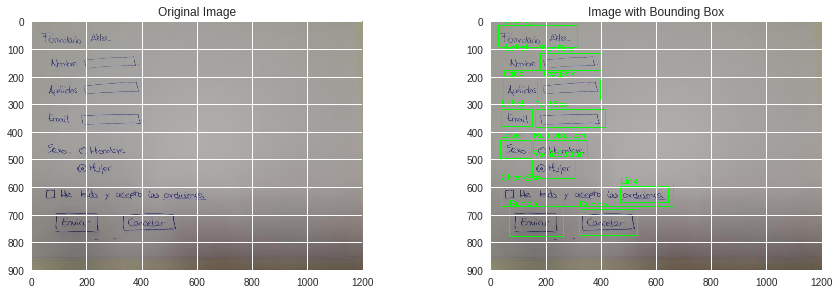

In [ ]:
# data visualization on a random sample of images

for i in range(6):
  # random selection of image
  image_uri = images_boxable['image_uri'][random.randint(0,len(images_boxable)-1)]
  img = io.imread(image_uri)
  height, width, _ = img.shape
  print(img.shape)
  
  # original image plot
  plt.figure(figsize=(48,32))
  plt.subplot(i+1,6,1)
  plt.title('Original Image')
  plt.imshow(img)
  
  # adding bounding bounding boxes to iamges
  img_id = image_uri[12:].replace('.png','')
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  img_bbox = img.copy()
  for index, row in bboxs.iterrows():
      row.head()
      xmin = int(row['XMin']*width)
      xmax = int(row['XMax']*width)
      ymin = int(row['YMin']*height)
      ymax = int(row['YMax']*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions['name']==label_name]
      class_name = class_series['class'].values[0]
      cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
      
  # image with bounding box plot    
  plt.subplot(i+1,6,2)
  plt.title('Image with Bounding Box')
  plt.imshow(img_bbox)
  plt.show()

In [ ]:
# directory for dataset path
base_path = 'sketchs/Dataset'

# creating a directory
!mkdir sketchs/Dataset

In [ ]:
# label_name for all classes
for cls in class_descriptions['class']:
  print(class_descriptions[class_descriptions['class']==cls])

                                   name     class
0  d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6  CheckBox
                                   name   class
1  69576625-a3c1-40bb-8947-936491484048  Button
                                   name  class
2  b9944914-2e80-4b6a-8874-0fe55d073c45  Label
                                   name        class
3  530d20f2-7260-42f1-bd42-bddca465c9e9  RadioButton
                                   name    class
4  c266ec15-593b-425f-a6e1-384c4df0a781  TextBox
                                   name    class
5  1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2  Heading
                                   name     class
6  a04aa534-942d-4640-af99-39851705e59b  ComboBox
                                   name class
7  66565887-d482-4579-ae34-d0ca1869f3d7  Link
                                   name  class
8  fcf1ba33-f9f4-4715-a999-e0d65bb7f09f  Image
                                   name      class
9  43525578-a7e1-4f18-9c3b-2c60952c1bb5  Paragraph


In [ ]:
#length of all classes in dataset
for cls in class_descriptions['class']:
  print('There are {} {} in the dataset'.format(len(annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]), cls))

There are 203 CheckBox in the dataset
There are 178 Button in the dataset
There are 756 Label in the dataset
There are 112 RadioButton in the dataset
There are 171 TextBox in the dataset
There are 212 Heading in the dataset
There are 58 ComboBox in the dataset
There are 43 Link in the dataset
There are 155 Image in the dataset
There are 113 Paragraph in the dataset


In [ ]:
#number of images per class in dataset
for cls in class_descriptions['class']:
  print('There are {} images which contain {} '.format(annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]['ImageID'].nunique(), cls))

There are 51 images which contain CheckBox 
There are 89 images which contain Button 
There are 132 images which contain Label 
There are 34 images which contain RadioButton 
There are 71 images which contain TextBox 
There are 109 images which contain Heading 
There are 28 images which contain ComboBox 
There are 25 images which contain Link 
There are 59 images which contain Image 
There are 41 images which contain Paragraph 


In [ ]:
# shuffle the ids of dataframe
def shuffle(df):
    index = list(df.index)
    random.seed(random.randint(0,99))
    random.shuffle(index)
    df = df.loc[index]
    df.reset_index()
    return df

In [ ]:
# supress warnings for chained assignments
pd.options.mode.chained_assignment = None
  
# sub classing of all classes in dataset
for cls in class_descriptions['class']:
  # extracting rows which contain  given class
  df = annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]
  
  # adding required rows
  df['image_name'] = df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
  df['image_uri'] = df.apply(lambda x: 'sketchs/web/' + x['image_name'], axis='columns')
  
  # shuffling rows of dataframe
  df = shuffle(df)
  
  # copying csv to their respective directory
  directory = base_path+'/'+cls
  csv_file = cls.lower()+'_img_uri.csv'
  if not os.path.exists(directory):
    os.makedirs(directory)
  df.to_csv(os.path.join(directory, csv_file), index = False)
  
  # printing sample of dataframe
  print(pd.read_csv(os.path.join(directory, csv_file)).head(1))

                                ImageID  width  height  \
0  5679fe0e-d661-4f54-b664-19f87d31a090   1600     800   

                              LabelName      XMin      YMin  region_width  \
0  d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6  0.506975  0.793472      0.237885   

   region_height      XMax     YMax                                image_name  \
0       0.174009  0.744861  0.96748  5679fe0e-d661-4f54-b664-19f87d31a090.png   

                                           image_uri  
0  sketchs/web/5679fe0e-d661-4f54-b664-19f87d31a0...  
                                ImageID  width  height  \
0  b0d1635f-2f9a-4285-8517-444cae326761    900     942   

                              LabelName      XMin      YMin  region_width  \
0  69576625-a3c1-40bb-8947-936491484048  0.507431  0.879902      0.473461   

   region_height      XMax      YMax  \
0       0.119675  0.980892  0.999577   

                                 image_name  \
0  b0d1635f-2f9a-4285-8517-444cae326761.png   

       

In [ ]:
# additional required variables

# list of all classes
classes = []
# list of directories asscoiated to different classes
saved_dirs = []
# 2d list of urls for each class
uris = []

for cls in class_descriptions['class']:
  classes.append(cls)
  directory = base_path+'/'+cls
  csv_file = cls.lower()+'_img_uri.csv'
  saved_dirs.append(directory)
  uris.append(pd.read_csv(os.path.join(directory, csv_file), usecols = ['image_uri']).values.flatten().tolist())
  
# printing a sample of each list
print(classes)
print(saved_dirs)
print(uris[0])

['CheckBox', 'Button', 'Label', 'RadioButton', 'TextBox', 'Heading', 'ComboBox', 'Link', 'Image', 'Paragraph']
['sketchs/Dataset/CheckBox', 'sketchs/Dataset/Button', 'sketchs/Dataset/Label', 'sketchs/Dataset/RadioButton', 'sketchs/Dataset/TextBox', 'sketchs/Dataset/Heading', 'sketchs/Dataset/ComboBox', 'sketchs/Dataset/Link', 'sketchs/Dataset/Image', 'sketchs/Dataset/Paragraph']
['sketchs/web/5679fe0e-d661-4f54-b664-19f87d31a090.png', 'sketchs/web/236b436f-ce60-4a25-8e81-3603552536e3.png', 'sketchs/web/8e594bc4-1057-4c65-b1e7-7f6c3effe522.png', 'sketchs/web/8cea0797-e148-4eff-be0a-08bd8dad494a.png', 'sketchs/web/4e16d9d6-be4b-46f5-99e1-8d144b11ecde.png', 'sketchs/web/722b8c8f-7975-4fc7-abde-b27b3bd37883.png', 'sketchs/web/e6b36cb6-83a0-4865-8b33-52822722ef50.png', 'sketchs/web/5679fe0e-d661-4f54-b664-19f87d31a090.png', 'sketchs/web/3c0e378f-434b-451b-a88a-99fac1e8d4ee.png', 'sketchs/web/9e699db6-adf6-42ea-a833-1a4e5633f029.png', 'sketchs/web/995d99ba-02a3-42ed-9841-fa7b7a6e967c.png', '

In [ ]:
# saving images to their respective folders
for i in range(len(classes)):
    saved_dir = saved_dirs[i]
    for uri in uris[i]:
        copy(uri, saved_dir)

In [ ]:
# Save images to test and test directory

# uris of training and testing folders
try:
  train_path = base_path+'/'+'train'
  os.makedirs(train_path)
  test_path = base_path+'/'+'test'
  os.makedirs(test_path)
except FileExistsError :
  print('')

# list of all images present in dataset directory
all_imgs = os.listdir('sketchs/web')
all_imgs = [f for f in all_imgs if not f.startswith('.')]
all_imgs = [f for f in all_imgs if not f.endswith('.html')]

# shuffling image list
random.seed(random.randint(0,99))
random.shuffle(all_imgs)

# splitting data in 80:20 ratio for training and testing sets
train_imgs = all_imgs[:int(len(all_imgs)*0.8)]
test_imgs = all_imgs[int(len(all_imgs)*0.8):]
    
# copy images to train directory
for j in range(len(train_imgs)):
    original_path = os.path.join('sketchs/web', train_imgs[j])
    new_path = os.path.join(train_path, train_imgs[j])
    copy(original_path, new_path)
    
# copy images to test directory
for j in range(len(test_imgs)):
    original_path = os.path.join('sketchs/web', test_imgs[j])
    new_path = os.path.join(test_path, test_imgs[j])
    copy(original_path, new_path)

In [ ]:
# number of images in each set
print('number of training images: ', len(os.listdir(train_path)))
print('number of test images: ', len(os.listdir(test_path)))

number of training images:  119
number of test images:  30


In [ ]:
# saving rows associated to training images as a txt file seperated

# list of all images id present in train directory
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]
train_imgs = [name for name in train_imgs if not name.endswith('.html')]
train_imgs_ids = list(map(lambda x: x[:-4], train_imgs))

# various dataframe operations for extracting required data format
train_df= annotations_bbox[annotations_bbox.ImageID.isin(train_imgs_ids)]
train_df['XMin'] = train_df.apply(lambda x: x['XMin'] * x['width'], axis='columns')
train_df['XMax'] = train_df.apply(lambda x: x['XMax'] * x['width'], axis='columns')
train_df['YMin'] = train_df.apply(lambda x: x['YMin'] * x['height'], axis='columns')
train_df['YMax'] = train_df.apply(lambda x: x['YMax'] * x['height'], axis='columns')
train_df['FileName'] = train_df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
train_df = train_df.join(class_descriptions.set_index('name'), on='LabelName')
train_df.rename(columns={'class': 'ClassName'}, inplace=True)
train_df = train_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']]

# shuffling dataframe rows and storing as a txt file
train_df = shuffle(train_df)
train_df.to_csv(base_path + '/train/' + 'train_annotation.txt' , header = False, index = False)

# printing sample of dataframe
print('Parse train_imgs ' + str(len(train_imgs_ids)) + '; Number of boxes: ' + str(len(train_df)))
train_df.head(5)

Parse train_imgs 119; Number of boxes: 1554


,FileName,XMin,XMax,YMin,YMax,ClassName
809,a6c59f33-2285-4644-97aa-52f193d4e5ce.png,91.216216,617.229766,548.544288,641.202516,Heading
1157,bc18ff8e-a345-40ed-9f3e-ccaf0ca2141f.png,704.273520,738.461556,197.231009,248.496831,Label
231,5679fe0e-d661-4f54-b664-19f87d31a090.png,74.596173,578.560931,469.138527,592.486549,Label
1153,bc18ff8e-a345-40ed-9f3e-ccaf0ca2141f.png,365.811960,454.700850,626.724690,683.686716,Link
474,653aa448-284d-4664-b993-734097595667.png,284.048699,388.505319,608.172120,782.306534,Image


In [ ]:
# saving rows associated to testing images as a txt file seperated

# list of all images id present in test directory
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]
test_imgs = [name for name in test_imgs if not name.endswith('.html')]
test_imgs_ids = list(map(lambda x: x[:-4], test_imgs))

# various dataframe operations for extracting required data format
test_df= annotations_bbox[annotations_bbox.ImageID.isin(test_imgs_ids)]
test_df['XMin'] = test_df.apply(lambda x: x['XMin'] * x['width'], axis='columns')
test_df['XMax'] = test_df.apply(lambda x: x['XMax'] * x['width'], axis='columns')
test_df['YMin'] = test_df.apply(lambda x: x['YMin'] * x['height'], axis='columns')
test_df['YMax'] = test_df.apply(lambda x: x['YMax'] * x['height'], axis='columns')
test_df['FileName'] = test_df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
test_df = test_df.join(class_descriptions.set_index('name'), on='LabelName')
test_df.rename(columns={'class': 'ClassName'}, inplace=True)
test_df = test_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']]

# shuffling dataframe rows and storing as a txt file
test_df = shuffle(test_df)
test_df.to_csv(base_path + '/test/' + 'test_annotation.txt' , header = False, index = False)

# printing sample of dataframe
print('Parse test_imgs ' + str(len(test_imgs_ids)) + '; Number of boxes: ' + str(len(test_df)))
test_df.head(5)

Parse test_imgs 30; Number of boxes: 447


,FileName,XMin,XMax,YMin,YMax,ClassName
1306,eaa0ceec-7f26-42b2-81a7-b8cd52416fec.png,741.88032,1047.293400,771.408270,886.471560,Button
51,f1f0f46b-4430-4227-ab3a-24ad1192728e.png,14.68428,330.102786,146.267953,271.535469,CheckBox
1839,da54575a-4e89-49aa-af1a-c4d8490ba57b.png,609.99996,788.999968,512.791650,587.791652,Label
1829,da54575a-4e89-49aa-af1a-c4d8490ba57b.png,938.00004,1093.000036,339.791653,439.791654,Label
1939,b23c633e-f3d1-42ef-bbda-d6ddaeb53a3c.png,48.00000,529.000006,418.791667,499.791667,TextBox


In [ ]:
# adding path to trainig data and testing data

def add_str_to_lines(f_name, str_to_add):
    with open(f_name, "r") as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            lines[index] = str_to_add + line.strip() + "\n"

    with open(f_name, "w") as f:
        for line in lines:
            f.write(line)

add_str_to_lines('sketchs/Dataset/train/train_annotation.txt', 'sketchs/Dataset/train/')
add_str_to_lines('sketchs/Dataset/test/test_annotation.txt', 'sketchs/Dataset/test/')

In [ ]:
# Configurations for training and testing

class Config:
	def __init__(self):
		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
		self.anchor_box_scales = [128, 256, 512] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [175.939, 176.779, 177.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 8

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

In [ ]:
# data from annotation file

def get_data(input_path):
	"""Parsing the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
      
	"""
	found_bg = False
	all_imgs = {}
	classes_count = {}
	class_mapping = {}
	visualise = True
	i = 1
	
	with open(input_path,'r') as f:
		print('Parsing annotation files')
		for line in f:
			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1
      
      # spliting lines
			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1---------------------
			#	|						|              |
			#	|						|              |
			#	|						|              |
			#	|						|              | 
			#	---------------------x2,y2

			(filename,x1,x2,y1,y2,class_name) = line_split
			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(float(x1)), 'x2': int(float(x2)), 'y1': int(float(y1)), 'y2': int(float(y2))})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping
  
# function testing
print(get_data('sketchs/Dataset/train/train_annotation.txt'))

Parsing annotation files
idx=1554([{'filepath': 'sketchs/Dataset/train/a6c59f33-2285-4644-97aa-52f193d4e5ce.png', 'width': 900, 'height': 1200, 'bboxes': [{'class': 'Heading', 'x1': 91, 'x2': 617, 'y1': 548, 'y2': 641}, {'class': 'Button', 'x1': 194, 'x2': 589, 'y1': 1071, 'y2': 1200}, {'class': 'Label', 'x1': 110, 'x2': 585, 'y1': 554, 'y2': 636}, {'class': 'ComboBox', 'x1': 104, 'x2': 258, 'y1': 943, 'y2': 1014}, {'class': 'RadioButton', 'x1': 117, 'x2': 411, 'y1': 316, 'y2': 419}, {'class': 'Label', 'x1': 95, 'x2': 868, 'y1': 109, 'y2': 206}, {'class': 'RadioButton', 'x1': 120, 'x2': 548, 'y1': 430, 'y2': 512}, {'class': 'RadioButton', 'x1': 126, 'x2': 500, 'y1': 212, 'y2': 302}, {'class': 'Label', 'x1': 109, 'x2': 460, 'y1': 667, 'y2': 741}, {'class': 'Label', 'x1': 659, 'x2': 785, 'y1': 859, 'y2': 899}, {'class': 'ComboBox', 'x1': 320, 'x2': 453, 'y1': 932, 'y2': 1028}, {'class': 'TextBox', 'x1': 117, 'x2': 755, 'y1': 747, 'y2': 818}, {'class': 'Label', 'x1': 106, 'x2': 538, 'y1':

In [ ]:
# ROI Pooling Layer

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
        
    '''
    def __init__(self, pool_size, num_rois, **kwargs):
        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):
            x = K.cast(rois[0, roi_idx, 0], 'int32')
            y = K.cast(rois[0, roi_idx, 1], 'int32')
            w = K.cast(rois[0, roi_idx, 2], 'int32')
            h = K.cast(rois[0, roi_idx, 3], 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                
        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# VGG16 model

def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):
    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

In [ ]:
# RPN layer

def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
    
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
        
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

In [ ]:
# Classifier Layer

def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 11):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,11)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)
    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

In [ ]:
# Intersection of Union Metric

def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [ ]:
# Get new image size and augment the image

# get new image size
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

# augment the image
def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = deepcopy(img_data)
	img = cv2.imread(img_data_aug['filepath'])
  
	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

In [ ]:
# Calculate the rpn for all anchors

def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
      
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth
	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):
					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region
	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos


In [ ]:
# Generation of ground truth vectors

def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
    
	"""
	while True:
		for img_data in all_img_data:
			try:
				# read in image, and optionally add augmentation
				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image
				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [ ]:
# Loss functions

lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
                           
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
        
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):
            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [ ]:
# Non maximum supression

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection
        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs


In [ ]:
# Functions for position regressor

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
        
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
        
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(deepcopy(coords))
            y_class_regr_label.append(deepcopy(labels))
        else:
            y_class_regr_coords.append(deepcopy(coords))
            y_class_regr_label.append(deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [ ]:
# Convertion rpn layer to roi bboxes

def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
		boxes: coordinates for bboxes (on the feature map)
      
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

# **Training**

In [ ]:
# Creating a directory for model
!mkdir 'sketchs/model'

# Downloading pretrained vgg weights file based from GitHub
#!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

# Moving file to model directory
#!mv vgg16_weights_tf_dim_ordering_tf_kernels.h5 'sketchs/model'

mkdir: cannot create directory ‘sketchs/model’: File exists


In [ ]:
# Base path directory
base_path = 'sketchs'

# Training data (annotation file)
train_path =  'sketchs/Dataset/train/train_annotation.txt'

# Number of RoIs to process at once.
num_rois = 4 

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_vgg.hdf5')

# Record data (used to save the losses, classification accuracy and mean average precision)
record_path = os.path.join(base_path, 'model/record.csv')

base_weight_path = os.path.join(base_path, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(base_path, 'model/model_vgg_config.pickle')

In [ ]:
# Create the config

C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [ ]:
# data object from annotation file
# This step will spend some time to load the data        #

st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60))

Parsing annotation files
idx=1554
Spend 0.02 mins to load the data


In [ ]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Label': 702, 'ComboBox': 55, 'RadioButton': 112, 'Button': 166, 'Image': 136, 'TextBox': 163, 'Heading': 201, 'Paragraph': 105, 'CheckBox': 199, 'Link': 39, 'bg': 0}
#    class_mapping: {'Label': 0, 'ComboBox': 1, 'RadioButton': 2, 'Button': 3, 'Image': 4, 'TextBox': 5, 'Heading': 6, 'Paragraph': 7, 'CheckBox': 8, 'Link': 9, 'bg': 10}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open('model_vgg_config.pickle', 'wb') as config_f:
	pickle.dump(C,config_f)

move('model_vgg_config.pickle', 'sketchs/model')  
print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'Button': 137,
 'CheckBox': 144,
 'ComboBox': 42,
 'Heading': 177,
 'Image': 134,
 'Label': 557,
 'Link': 36,
 'Paragraph': 107,
 'RadioButton': 86,
 'TextBox': 134,
 'bg': 0}
Num classes (including bg) = 11
{'Heading': 0, 'Label': 1, 'Link': 2, 'Image': 3, 'Button': 4, 'TextBox': 5, 'Paragraph': 6, 'CheckBox': 7, 'RadioButton': 8, 'ComboBox': 9, 'bg': 10}
Config has been written to sketchs/model/model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [ ]:
# Shuffle the images with seed
random.seed(43)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 119


In [ ]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=1600 width=404
Resized image:  height=2376 width=600 C.im_size=600
Feature map size: height=148 width=37 C.rpn_stride=8
(1, 2376, 600, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 148, 37, 18)
Shape of y_rpn_regr (1, 148, 37, 72)
{'filepath': 'sketchs/Dataset/train/4e16d9d6-be4b-46f5-99e1-8d144b11ecde.png', 'width': 404, 'height': 1600, 'bboxes': [{'class': 'CheckBox', 'x1': 108, 'x2': 187, 'y1': 967, 'y2': 1283}, {'class': 'CheckBox', 'x1': 109, 'x2': 201, 'y1': 1304, 'y2': 1565}, {'class': 'CheckBox', 'x1': 87, 'x2': 177, 'y1': 342, 'y2': 643}, {'class': 'CheckBox', 'x1': 102, 'x2': 184, 'y1': 666, 'y2': 964}, {'class': 'CheckBox', 'x1': 85, 'x2': 175, 'y1': 41, 'y2': 301}, {'class': 'Label', 'x1': 309, 'x2': 385, 'y1': 37, 'y2': 321}, {'class': 'TextBox', 'x1': 309, 'x2': 386, 'y1': 340, 'y2': 680}, {'class': 'Label', 'x1': 208, 'x2': 277, 'y1': 25, 'y2': 881}]}
Number of positive anchors for this image: 24
(array([  8,  12,  25,  29,  30,

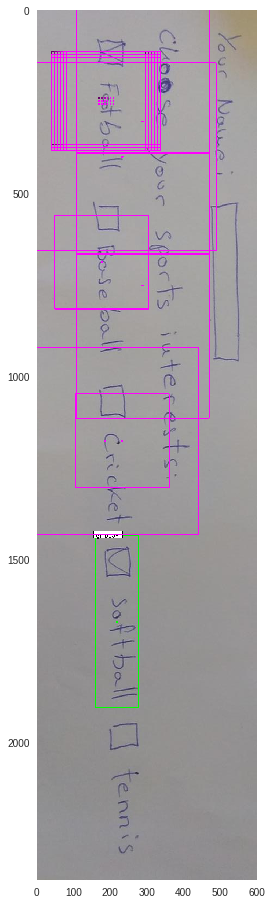

In [ ]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):
        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(16,16))
plt.grid()
plt.imshow(img)
plt.show()


In [ ]:
# Building model

input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
This is the first time of training
loading weights from sketchs/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder https://github.com/fchollet/keras/tree/master/keras/applications


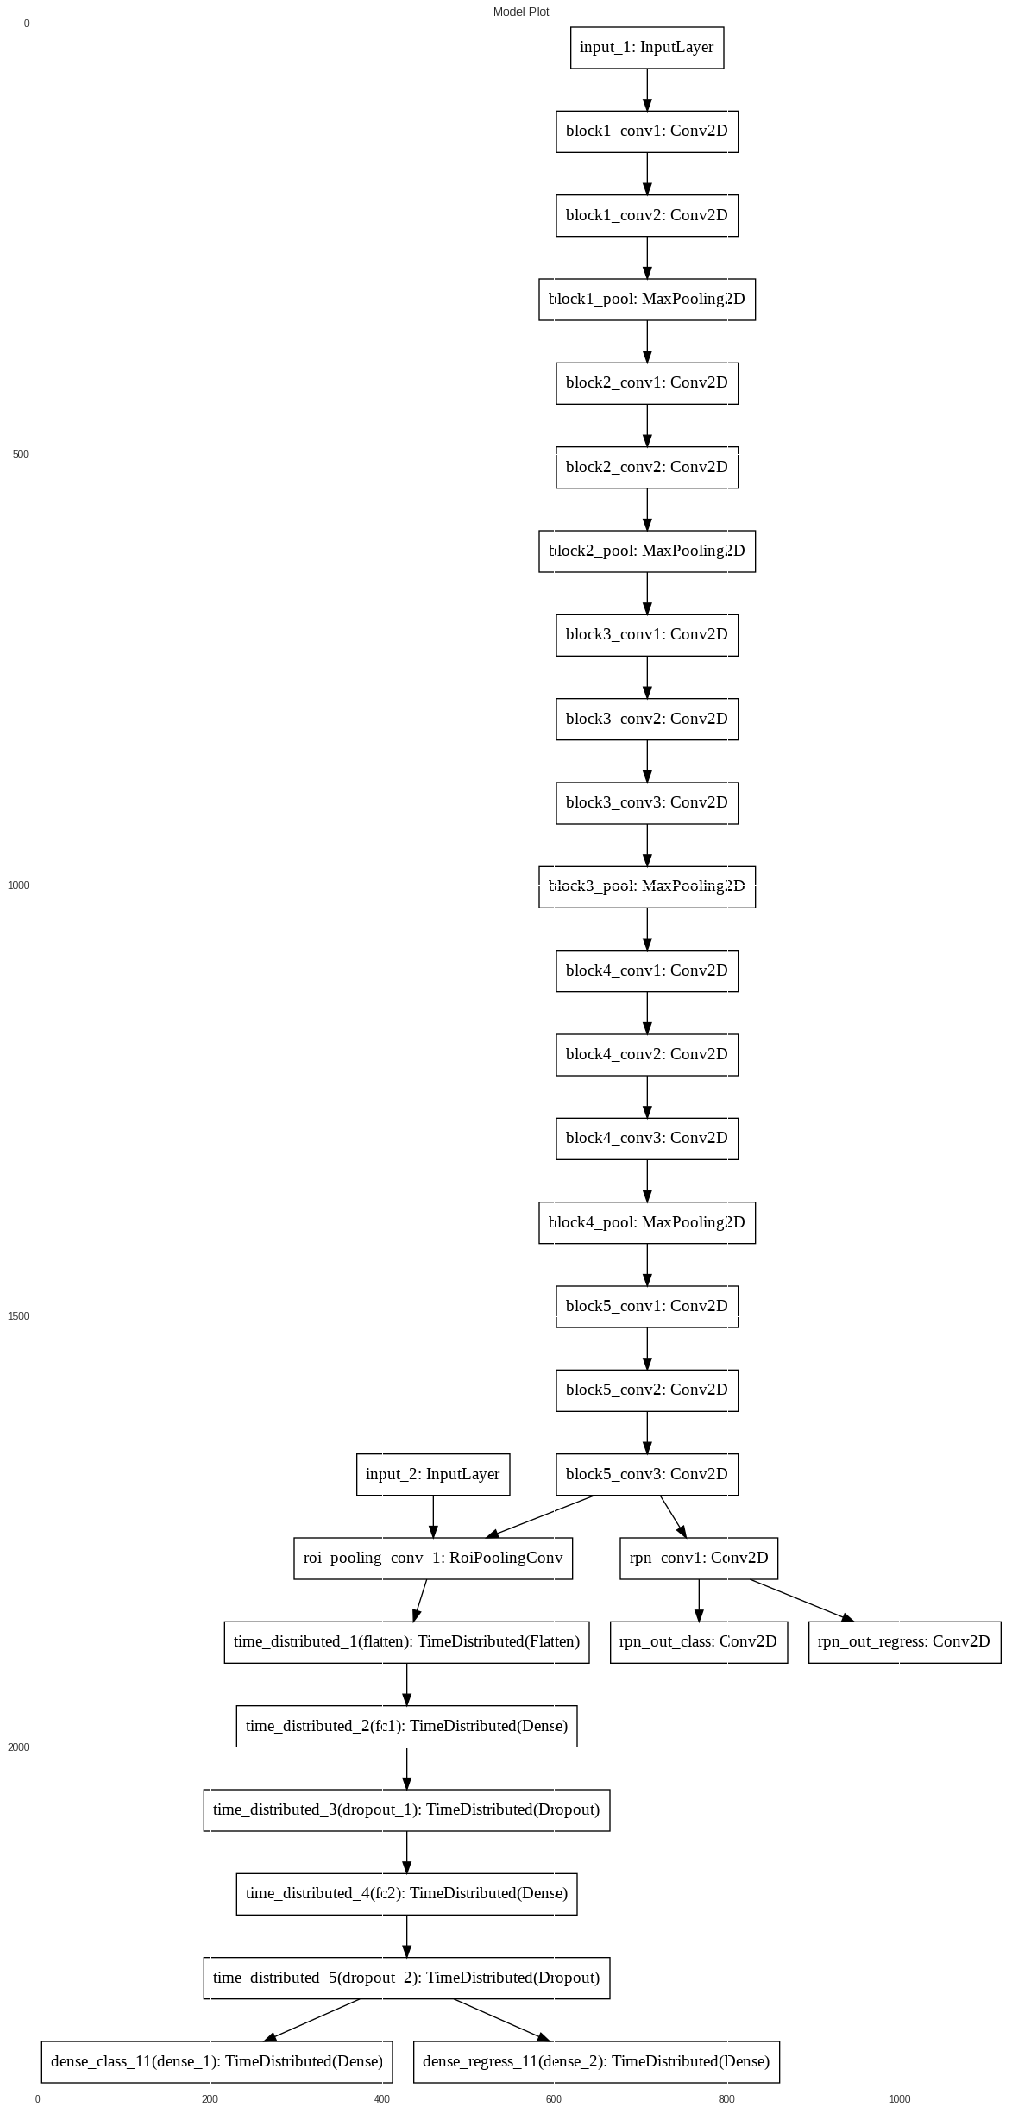

In [ ]:
# Model Vizualzation

plot_model(model_all, to_file='sketchs/model_all.png')

model_plot = io.imread('sketchs/model_all.png')

# model viz image plot
plt.figure(figsize=(38,38))
plt.title('Model Plot')
plt.imshow(model_plot)
plt.show()

In [ ]:
# Model Compilation

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [ ]:
# Training setting

total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 100
num_epochs = 30
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [ ]:
# Training Step

start_time = time.time()
for epoch_num in range(num_epochs):
  try:
      progbar = generic_utils.Progbar(epoch_length)
      print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))

      r_epochs += 1

      while True:
          try:
              if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                  mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                  rpn_accuracy_rpn_monitor = []
                  if mean_overlapping_bboxes == 0:
                      print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

              # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
              X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

              # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
              loss_rpn = model_rpn.train_on_batch(X, Y)

              # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
              P_rpn = model_rpn.predict_on_batch(X)

              # R: bboxes (shape=(300,4))
              # Convert rpn layer to roi bboxes
              R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

              # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
              # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
              # Y1: one hot code for bboxes from above => x_roi (X)
              # Y2: corresponding labels and corresponding gt bboxes
              X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

              # If X2 is None means there are no matching bboxes
              if X2 is None:
                  rpn_accuracy_rpn_monitor.append(0)
                  rpn_accuracy_for_epoch.append(0)
                  continue

              # Find out the positive anchors and negative anchors
              neg_samples = np.where(Y1[0, :, -1] == 1)
              pos_samples = np.where(Y1[0, :, -1] == 0)

              if len(neg_samples) > 0:
                  neg_samples = neg_samples[0]
              else:
                  neg_samples = []

              if len(pos_samples) > 0:
                  pos_samples = pos_samples[0]
              else:
                  pos_samples = []

              rpn_accuracy_rpn_monitor.append(len(pos_samples))
              rpn_accuracy_for_epoch.append((len(pos_samples)))

              if C.num_rois > 1:
                  # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                  if len(pos_samples) < C.num_rois//2:
                      selected_pos_samples = pos_samples.tolist()
                  else:
                      selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                  # Randomly choose (num_rois - num_pos) neg samples
                  try:
                      selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                  except:
                      selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                  # Save all the pos and neg samples in sel_samples
                  sel_samples = selected_pos_samples + selected_neg_samples
              else:
                  # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                  selected_pos_samples = pos_samples.tolist()
                  selected_neg_samples = neg_samples.tolist()
                  if np.random.randint(0, 2):
                      sel_samples = random.choice(neg_samples)
                  else:
                      sel_samples = random.choice(pos_samples)

              # training_data: [X, X2[:, sel_samples, :]]
              # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
              #  X                     => img_data resized image
              #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
              #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
              #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
              loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

              losses[iter_num, 0] = loss_rpn[1]
              losses[iter_num, 1] = loss_rpn[2]

              losses[iter_num, 2] = loss_class[1]
              losses[iter_num, 3] = loss_class[2]
              losses[iter_num, 4] = loss_class[3]

              iter_num += 1

              progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                        ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

              if iter_num == epoch_length:
                  loss_rpn_cls = np.mean(losses[:, 0])
                  loss_rpn_regr = np.mean(losses[:, 1])
                  loss_class_cls = np.mean(losses[:, 2])
                  loss_class_regr = np.mean(losses[:, 3])
                  class_acc = np.mean(losses[:, 4])

                  mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                  rpn_accuracy_for_epoch = []

                  if C.verbose:
                      print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                      print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                      print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                      print('Loss RPN regression: {}'.format(loss_rpn_regr))
                      print('Loss Detector classifier: {}'.format(loss_class_cls))
                      print('Loss Detector regression: {}'.format(loss_class_regr))
                      print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                      print('Elapsed time: {}'.format(time.time() - start_time))
                      elapsed_time = (time.time()-start_time)/60

                  curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                  iter_num = 0
                  start_time = time.time()

                  if curr_loss < best_loss:
                      if C.verbose:
                          print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                      best_loss = curr_loss
                      model_all.save_weights(C.model_path)

                  new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                             'class_acc':round(class_acc, 3), 
                             'loss_rpn_cls':round(loss_rpn_cls, 3), 
                             'loss_rpn_regr':round(loss_rpn_regr, 3), 
                             'loss_class_cls':round(loss_class_cls, 3), 
                             'loss_class_regr':round(loss_class_regr, 3), 
                             'curr_loss':round(curr_loss, 3), 
                             'elapsed_time':round(elapsed_time, 3), 
                             'mAP': 0}

                  record_df = record_df.append(new_row, ignore_index=True)
                  record_df.to_csv(record_path, index=0)

                  break

          except Exception as e:
              print('Exception: {}'.format(e))
              continue
              
  except KeyboardInterrupt:
    print('KeyboardInterrupt called')
    inp = input('Do you want to save weights- Yes[y], No[n]: ')
    if inp.lower() == 'y':
      model_all.save_weights(C.model_path)
      print('weights saved')
    else:
      print('weights are not saved')
    break

print('Training complete, exiting.')


Epoch 1/30
Instructions for updating:
Use tf.cast instead.
100/100 [==============================] - 666s 7s/step - rpn_cls: 5.3977 - rpn_regr: 1.3120 - final_cls: 1.7509 - final_regr: 0.3546
Mean number of bounding boxes from RPN overlapping ground truth boxes: 3.7079646017699117
Classifier accuracy for bounding boxes from RPN: 0.705
Loss RPN classifier: 4.481615311205387
Loss RPN regression: 1.2533864332735538
Loss Detector classifier: 1.5173811138048767
Loss Detector regression: 0.36038010612130167
Total loss: 7.612762964405119
Elapsed time: 665.5177233219147
Total loss decreased from inf to 7.612762964405119, saving weights
Epoch 2/30
100/100 [==============================] - 472s 5s/step - rpn_cls: 3.3173 - rpn_regr: 1.1150 - final_cls: 1.4144 - final_regr: 0.3380
Mean number of bounding boxes from RPN overlapping ground truth boxes: 2.660377358490566
Classifier accuracy for bounding boxes from RPN: 0.7275
Loss RPN classifier: 3.328811837838948
Loss RPN regression: 1.09739666372

In [ ]:
# Installing PyDrive wrapper & importing related libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentication and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# upload weights and record file to google drive.
upload = drive.CreateFile({'title': 'model_frcnn_vgg.hdf5'})
upload.SetContentFile('sketchs/model/model_frcnn_vgg.hdf5')
upload.Upload()
print('Uploaded file with ID {}'.format(upload.get('id')))
upload = drive.CreateFile({'title': 'model_vgg_config.pickle'})
upload.SetContentFile('sketchs/model/model_vgg_config.pickle')
upload.Upload()
print('Uploaded file with ID {}'.format(upload.get('id')))
upload = drive.CreateFile({'title': 'record.csv'})
upload.SetContentFile('sketchs/model/record.csv')
upload.Upload()
print('Uploaded file with ID {}'.format(upload.get('id')))

Uploaded file with ID 1McAXpIHQ3OhRVGGcFJn9_oKR0Hq3Ywsk
Uploaded file with ID 1SbBcae8eJDV_7wNkCkQHR95QTmavb8eL
Uploaded file with ID 1qtv5exLRrHXVCEZjrRrAsaP__7RSs5nT


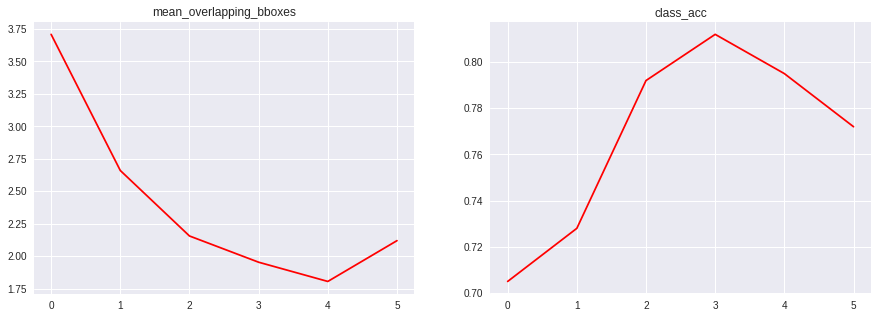

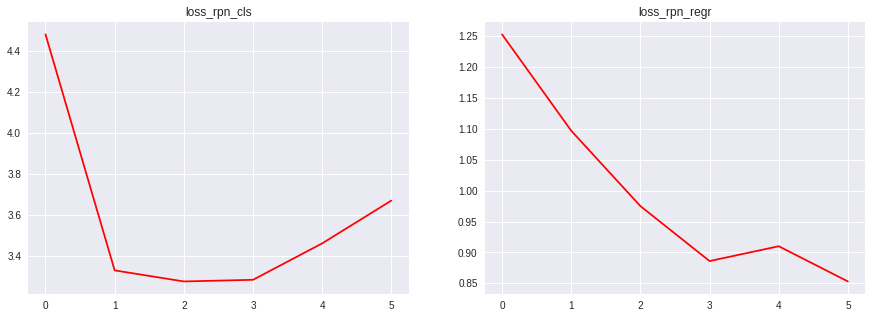

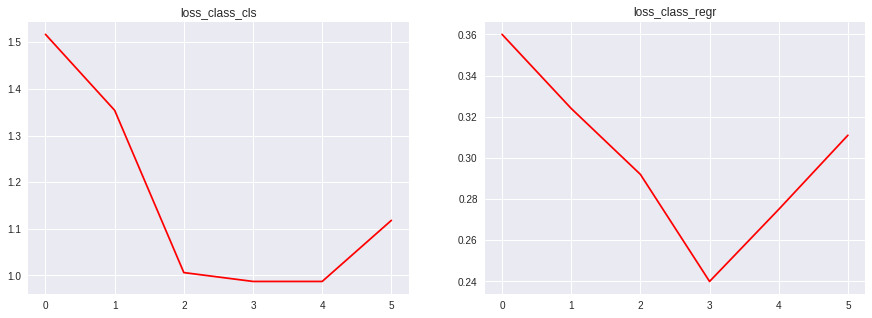

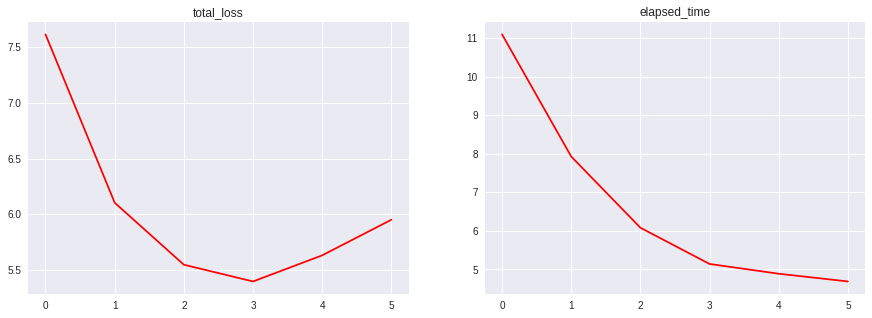

In [ ]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')
plt.show()

# **Testing**

In [ ]:
# Functions for changing format based of config

def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [ ]:
# Loading of trained weights and features to be passed

num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from sketchs/model/model_frcnn_vgg.hdf5


In [ ]:
# Switch key value for class mapping

class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Heading', 1: 'Label', 2: 'Link', 3: 'Image', 4: 'Button', 5: 'TextBox', 6: 'Paragraph', 7: 'CheckBox', 8: 'RadioButton', 9: 'ComboBox', 10: 'bg'}


In [ ]:
# Selecting random sample of images
test_path = 'sketchs/Dataset/test'
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]
test_imgs = [name for name in test_imgs if not name.endswith('.html')]
test_imgs = [name for name in test_imgs if not name.endswith('.txt')]

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

f1f0f46b-4430-4227-ab3a-24ad1192728e.png
Elapsed time = 3.3321800231933594
[]


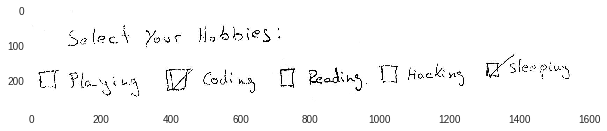

ae3de36d-ba93-4a5d-829c-38fa0b865812.png
Elapsed time = 0.9443166255950928
[]


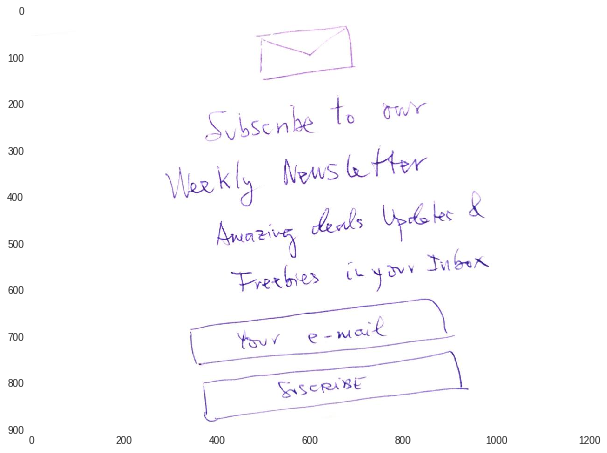

236b436f-ce60-4a25-8e81-3603552536e3.png
Elapsed time = 1.3589799404144287
[]


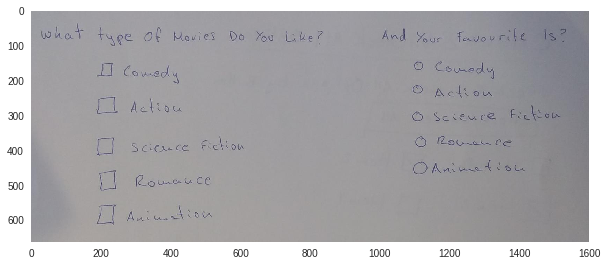

13b9f109-f532-471a-8f39-f19eef551919.png
Elapsed time = 2.589543342590332
[]


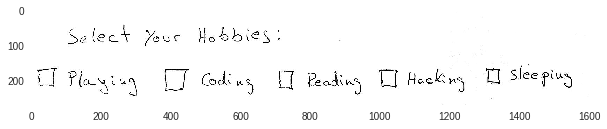

3892666c-c7c7-4b69-9000-9f050d2ca7fb.png
Elapsed time = 0.962364673614502
[]


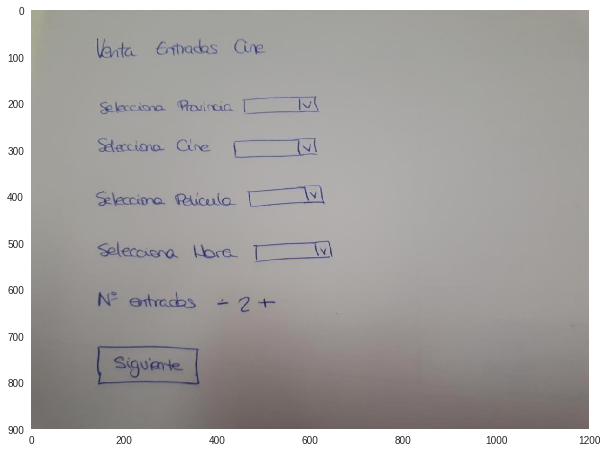

bd73cef8-a70e-483e-b0f5-81a7a81ca95d.png
Elapsed time = 0.932044506072998
[]


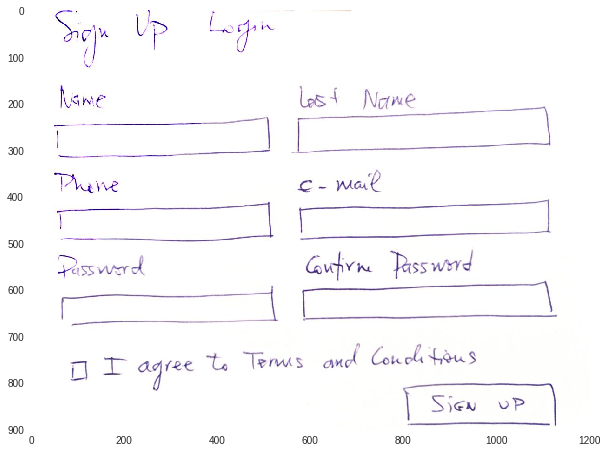

aa7e1723-0f7c-4932-bca6-0407dc244a1f.png
Elapsed time = 0.9729993343353271
[]


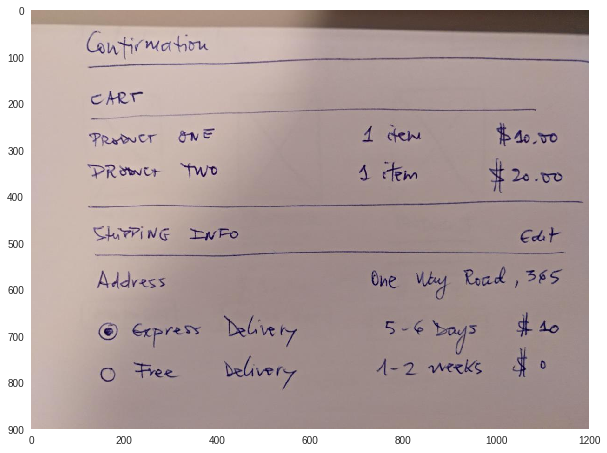

236b436f-ce60-4a25-8e81-3603552536e3.png
Elapsed time = 1.3884029388427734
[]


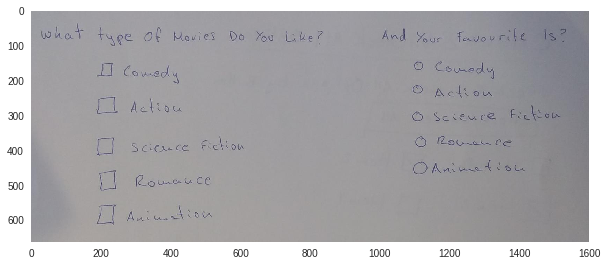

b61a2a6c-c46d-4575-a091-3508bf0b2b88.png
Elapsed time = 0.9428248405456543
[]


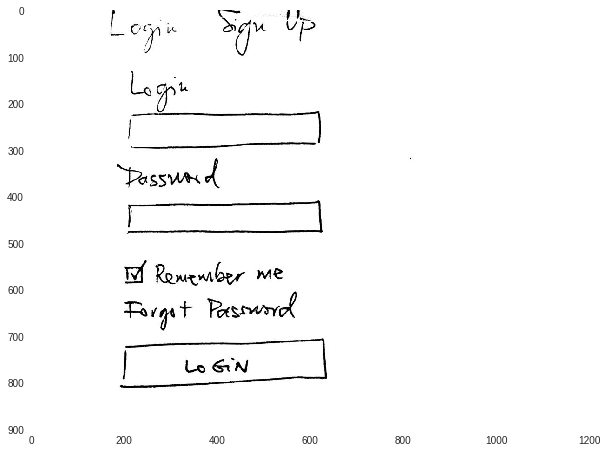

9f638ca2-de14-47dd-9f81-c697e849c3c5.png
Elapsed time = 0.9749493598937988
[]


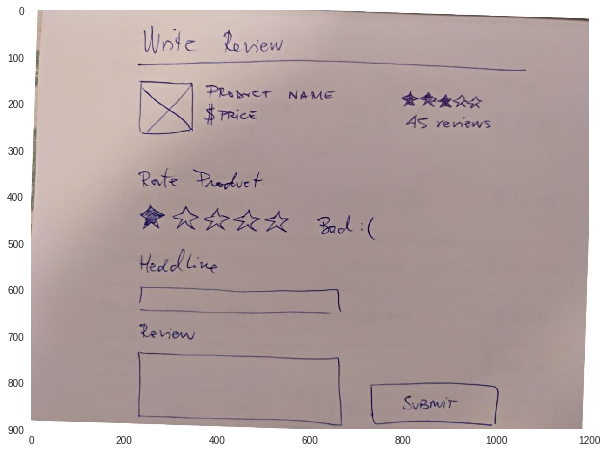

722b8c8f-7975-4fc7-abde-b27b3bd37883.png
Elapsed time = 1.281968116760254
[]


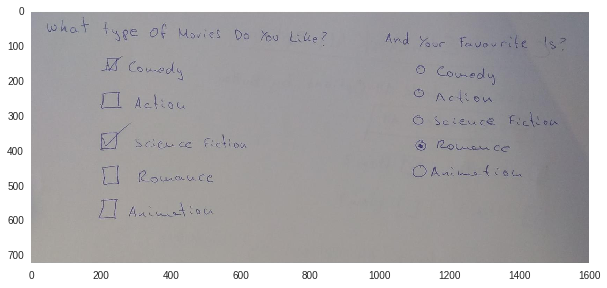

b04dc998-9b68-4d01-9670-0727d0d43617.png
Elapsed time = 0.9292283058166504
[]


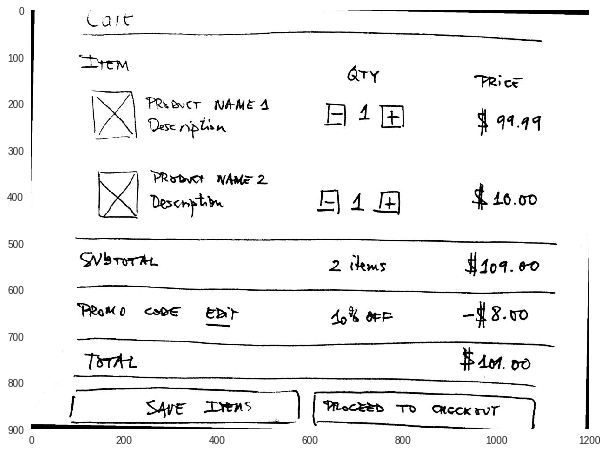

In [ ]:
# Printing a sample of predictions

# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
#Measuring mAP

def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	return T, P

def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
    
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [ ]:
# Class mappings present in data

print(class_mapping)

{0: 'Heading', 1: 'Label', 2: 'Link', 3: 'Image', 4: 'Button', 5: 'TextBox', 6: 'Paragraph', 7: 'CheckBox', 8: 'RadioButton', 9: 'ComboBox', 10: 'bg'}


In [ ]:
# Testing data parsing

test_imgs, _, _ = get_data(test_path+'/test_annotation.txt')

Parsing annotation files
idx=447

In [ ]:
T = {}
P = {}
mAPs = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)

    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/30
Elapsed time = 1.0223593711853027
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
mAP = 1.0
1/30
Elapsed time = 2.5788614749908447
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
CheckBox AP: 1.0
mAP = 1.0
2/30
Elapsed time = 0.890873908996582
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
CheckBox AP: 1.0
Link AP: 1.0
mAP = 1.0
3/30
Elapsed time = 0.9003159999847412
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
CheckBox AP: 1.0
Link AP: 1.0
mAP = 1.0
4/30
Elapsed time = 0.9220561981201172
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
CheckBox AP: 1.0
Link AP: 1.0
RadioButton AP: 1.0
mAP = 1.0
5/30
Elapsed time = 0.9386565685272217
Button AP: 1.0
Label AP: 1.0
Heading AP: 1.0
Image AP: 1.0
TextBox AP: 1.0
CheckBox AP: 1.0
Link AP: 1.0
RadioButton AP: 1.0
ComboBox AP: 1.0
mAP = 1.0
6/30
Elapsed time = 0.9111218452453613
Button AP: 1.0
Label AP: